# Fine-Tuning ALBERT using PEFT on the App Review Dataset

### Importing required libraries

In [1]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
from transformers import EarlyStoppingCallback
import torch

2024-08-02 03:03:39.657362: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-02 03:03:39.674191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 03:03:39.693557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 03:03:39.699440: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-02 03:03:39.714492: I tensorflow/core/platform/cpu_feature_guar

### Exploring the dataset and preprocessing

Here we concatenate two datasets. 4000 instances are manually annoated and the remaining 16000 are generated by ChatGPT through prompt fine-tuning

In [2]:
df1 = pd.read_excel('Data_Datasets_Unbalanced_dataset_unbalanced_4000.xlsx')
df2 = pd.read_excel('dataset_gpt_unbalanced_16000.xlsx')

df = pd.concat([df1, df2], ignore_index=True)
df.head()

,ID,review,label,new_label,remove_all_stopwords,remove_some_stopwords,stemming,lemmatization,no_stopwords
0,1,Not able to add freinds. It show something wen...,bug report,0,able add freinds show something went wrong rec...,not able add freinds show something went wrong...,not abl to add freind it show someth went wron...,not able to add freinds it show something went...,NaN
1,2,Calls keep dropping for no reason and is super...,bug report,0,calls keep dropping reason super annoying,calls keep dropping no reason super annoying,call keep drop for no reason and is super annoy,call keep dropping for no reason and is super ...,NaN
2,3,Can't access to my account solve this issue im...,bug report,0,cant access account solve issue immediately,cant access account solve issue immediately,cant access to my account solv thi issu immedi,cant access to my account solve this issue imm...,NaN
3,4,I don't know what's wrong with my own WhatsApp...,bug report,0,dont know whats wrong whatsapp working want si...,dont know whats wrong whatsapp not working wan...,i dont know what wrong with my own whatsapp it...,i dont know whats wrong with my own whatsapp i...,NaN
4,5,Cannot record audio while taking video,bug report,0,cannot record audio taking video,cannot record audio taking video,cannot record audio while take video,cannot record audio while taking video,NaN


user experience    6593
rating             5740
feature request    4410
bug report         3257
Name: label, dtype: int64


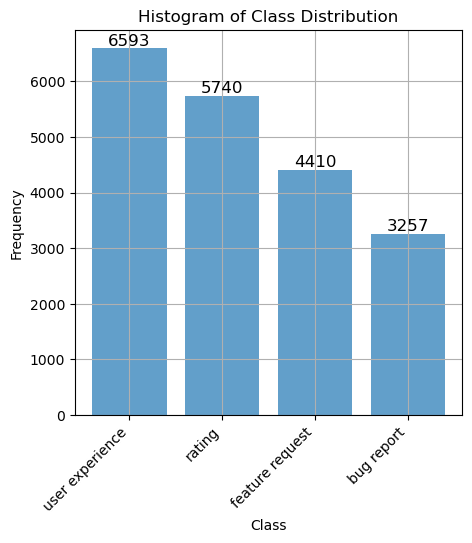

In [3]:
plt.figure(figsize=(5, 5))

# Get class labels and counts
# class_labels = df['label'].unique()
class_counts = df['label'].value_counts()
print(class_counts)

labels = []
counts = []
for label, count in class_counts.items():
    labels.append(label)
    counts.append(count)

# Create the bar plot
plt.bar(labels, counts, alpha=0.7)

# Annotate bars with exact values
for i, value in enumerate(class_counts):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom', fontsize=12)

# Set labels and title
plt.title('Histogram of Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.show()

In [4]:
df = df.drop(columns=['label'])
df = df.rename(columns={'new_label': 'label'})

In [5]:
df = df.drop(columns=['remove_all_stopwords', 'remove_some_stopwords', 'stemming', 'lemmatization', 'no_stopwords'])

In [6]:
df.head()

,ID,review,label
0,1,Not able to add freinds. It show something wen...,0
1,2,Calls keep dropping for no reason and is super...,0
2,3,Can't access to my account solve this issue im...,0
3,4,I don't know what's wrong with my own WhatsApp...,0
4,5,Cannot record audio while taking video,0


In [7]:
missing_reviews = df['review'].isnull()
print(missing_reviews.sum())

1


In [8]:
df = df.dropna(subset=['review'])

In [9]:
df['review'].isnull().sum()

0

In [10]:
df['label'].unique()

array([0, 1, 3, 2])

In [11]:
id2label = {0: 'bug report', 1: 'feature request', 2: 'rating', 3: 'user experience'}
label2id = {label: id for id, label in id2label.items()}

In [12]:
df = df.sample(frac=1, random_state=42)

In [13]:
df.head()

,ID,review,label
10650,21459,Great emulator This is probably the best emula...,2
2041,2042,it would be nice having new shows,1
8668,14560,Super App! Deeply-featured card search with pr...,1
1114,1115,Whenever atomic_number_53 try to open the app ...,0
13902,19254,!!!!!! ?????!!!!!! This app is a must have! Do...,2


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19999 entries, 10650 to 15796
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      19999 non-null  int64 
 1   review  19999 non-null  object
 2   label   19999 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 625.0+ KB


Here we split the data into training(80%), validation(10%) and testing(10%)

In [15]:
# Split the data into training, testing and validation sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [16]:
train_dataset = Dataset.from_dict(train_df)
test_dataset = Dataset.from_dict(test_df)
val_dataset = Dataset.from_dict(val_df)
dataset = DatasetDict({"train":train_dataset,"test":test_dataset, "validation": val_dataset})

In [17]:
dataset

DatasetDict({
    train: Dataset({
        features: ['ID', 'review', 'label'],
        num_rows: 15999
    })
    test: Dataset({
        features: ['ID', 'review', 'label'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['ID', 'review', 'label'],
        num_rows: 2000
    })
})

Here we load Albert Base V2 model which has 11.8M paramters. It was pretrained on a large corpus of English data in a self-supervised fashion.

In [18]:
model_checkpoint = 'albert-base-v2'

# generate classification model from model_checkpoint
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=4, id2label=id2label, label2id=label2id)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
model

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

Here we load the tokenizer for our ALBERT model. We use both padding and truncation and set the max length of tokenized text to 512

In [20]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

# create tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["review"]

    #tokenize and truncate text
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=512
    )

    return tokenized_inputs

In [21]:
# tokenize training and validation datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/15999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['ID', 'review', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15999
    })
    test: Dataset({
        features: ['ID', 'review', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['ID', 'review', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [22]:
# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [23]:
# import accuracy evaluation metric
accuracy = evaluate.load("accuracy")


# define an evaluation function to pass into trainer later
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

### Creating LoRA Configuration to train our model using PEFT

In [24]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=64,
                        lora_dropout=0.1,
                        target_modules = ["attention.query", "attention.key", "attention.value", "ffn", "attention.dense"])

In [25]:
# # Print the model architecture to identify target modules
# for name, module in model.named_modules():
#     print(name)

In [26]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 43,012 || all params: 11,729,672 || trainable%: 0.3667


1. Initialized leaning rate, batch size and no. of epochs
2. Implemented early stopping to avoid to model to overfit the data
3. Set an output directory to store the model checkpoints periodically
4. Added a little bit of weight decay to make the model less prone to overfitting
5. Created learning rate scheduler that adjusts the learning rate between epochs as the training progresses
6. After training we choose the best model(see the load_best_model_at_end parameter below)

In [27]:
# hyperparameters
lr = 1e-4
batch_size = 16
num_epochs = 20

In [28]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Add EarlyStoppingCallback to the trainer
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

Using device: cuda


In [29]:
# define training arguments
training_args = TrainingArguments(
    output_dir= model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    lr_scheduler_type="cosine",  # learning rate scheduler type
    warmup_ratio=0.1  # warmup ratio for lr scheduler
)

/mnt/iusers01/fse-ugpgt01/compsci01/y28520mp/.local/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [30]:
# creater trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

# train model
trainer.train()

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/mnt/iusers01/fse-ugpgt01/compsci01/y28520mp/.local/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,1.285900,1.112177,{'accuracy': 0.549}
2,0.669100,0.375019,{'accuracy': 0.888}
3,0.325200,0.308087,{'accuracy': 0.907}
4,0.260700,0.285413,{'accuracy': 0.916}
5,0.225700,0.259233,{'accuracy': 0.9255}
6,0.190500,0.250304,{'accuracy': 0.93}
7,0.169900,0.250406,{'accuracy': 0.93}
8,0.150200,0.265984,{'accuracy': 0.924}
9,0.130200,0.270870,{'accuracy': 0.929}


Trainer is attempting to log a value of "{'accuracy': 0.549}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/mnt/iusers01/fse-ugpgt01/compsci01/y28520mp/.local/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Trainer is attempting to log a value of "{'accuracy': 0.888}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/mnt/iusers01/fse-ugpgt01/compsci01/y28520mp/.local/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.


TrainOutput(global_step=4500, training_loss=0.3785927378336589, metrics={'train_runtime': 936.1859, 'train_samples_per_second': 341.791, 'train_steps_per_second': 10.682, 'total_flos': 1177347836864880.0, 'train_loss': 0.3785927378336589, 'epoch': 9.0})

### Testing the model on the test set

Along with accuracy, we evaluate the model using Micro F1 score as the dataset is imbalanced

In [31]:
# Reinitialize accuracy metric to avoid potential overwrite issues
accuracy = evaluate.load("accuracy")

# Get predictions and true labels
predictions = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Compute metrics
# Compute accuracy
accuracy = accuracy.compute(predictions=preds, references=labels)["accuracy"]
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="micro")

# Print the metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Micro Precision: {precision:.4f}")
print(f"Test Micro Recall: {recall:.4f}")
print(f"Test Micro F1-score: {f1:.4f}")

# Print classification report
class_report = classification_report(labels, preds, target_names=[id2label[i] for i in range(4)])
print("\nClassification Report:\n")
print(class_report)

/mnt/iusers01/fse-ugpgt01/compsci01/y28520mp/.local/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Test Accuracy: 0.9290
Test Micro Precision: 0.9290
Test Micro Recall: 0.9290
Test Micro F1-score: 0.9290

Classification Report:

                 precision    recall  f1-score   support

     bug report       0.86      0.92      0.89       329
feature request       0.94      0.88      0.91       453
         rating       0.98      0.92      0.95       570
user experience       0.92      0.97      0.94       648

       accuracy                           0.93      2000
      macro avg       0.92      0.92      0.92      2000
   weighted avg       0.93      0.93      0.93      2000



A couple of functions are defined below that would be used while making a single prediction

In [32]:
def preprocess_input(text, tokenizer):
    #tokenize and truncate text
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=512
    )

    return tokenized_inputs
def predict(text, model, tokenizer):
    model.eval()  # Set the model to evaluation mode
    inputs = preprocess_input(text, tokenizer)

    # Move inputs to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_class].item()

    return id2label[predicted_class], confidence

In [33]:
# Example usage
texts = ["This app has an amazing feature called voice search. You can literaly use your voice to search for something",
        "I do not like the theme of this app, otherwise the app is great",
        "good app",
        "Please put a search bar in the home page to search for all documents",
        "The coins do not update in the account after buying it from the store"]
for text in texts:
    predicted_class, confidence = predict(text, model, tokenizer)
    print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.4f}")

Predicted Class: feature request, Confidence: 0.9930
Predicted Class: rating, Confidence: 0.7541
Predicted Class: rating, Confidence: 0.9484
Predicted Class: feature request, Confidence: 0.9780
Predicted Class: bug report, Confidence: 0.9640


## Saving the model and tokenizer

In [34]:
output_dir = "./albert_model"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('./albert_model/tokenizer_config.json',
 './albert_model/special_tokens_map.json',
 './albert_model/spiece.model',
 './albert_model/added_tokens.json',
 './albert_model/tokenizer.json')

## Loading the saved model and tokenizer

In [35]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)
loaded_model = AutoModelForSequenceClassification.from_pretrained(
    output_dir, num_labels=4, id2label=id2label, label2id=label2id)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
# Example usage with the loaded model and tokenizer
texts = ["This app has an amazing feature called voice search. You can literaly use your voice to search for something",
        "I do not like the theme of this app, otherwise the app is great",
        "good app",
        "Please put a search bar in the home page to search for all documents",
        "The coins do not update in the account after buying it from the store"]
for text in texts:
    predicted_class, confidence = predict(text, loaded_model, tokenizer)
    print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.4f}")

Predicted Class: feature request, Confidence: 0.9930
Predicted Class: rating, Confidence: 0.7541
Predicted Class: rating, Confidence: 0.9484
Predicted Class: feature request, Confidence: 0.9780
Predicted Class: bug report, Confidence: 0.9640
